# Install dependencies

In [1]:
!pip install -U keras-tuner
!pip install lime
!pip install keras tensorflow

Requirement already up-to-date: keras-tuner in /home/sergio/anaconda3/lib/python3.7/site-packages (1.0.1)


In [2]:
!pip -V

pip 20.0.2 from /home/sergio/anaconda3/lib/python3.7/site-packages/pip (python 3.7)


# Import libraries

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error
from scipy import stats
import tensorflow as tf
import pickle as pk
# for ploting data
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# to explain local cases and understand the model's decision
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
# for matrix operation
import numpy as np

#for table manipulation
import pandas as pd

# garbage collector
import gc

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

Using TensorFlow backend.


# Adapter

In [4]:
class MyModel():
    def __init__(self,model,ty,max=False):
        self.model = model
        self.ty=ty
        self.max=True
    def predict(self, img):
        img = np.array(img)
        if(len(img.shape)==3):
            if(self.ty=='rf'):
                data=img[:,:,0].reshape(1, img.shape[0]*img.shape[1])
            else:
                data=img[:,:,0].reshape(1, img.shape[0], img.shape[1], 1)
        else:
            if(self.ty=='rf'):
                data=img[:,:,:,0].reshape(img.shape[0], img.shape[1]*img.shape[2])
            else:
                data=img[:,:,:,0].reshape(img.shape[0], img.shape[1], img.shape[2], 1)
        pred=self.model.predict(data)
        return pred

# configuration

In [5]:
batch_size = 128
num_classes = 10
epochs = 1

In [6]:
# input image dimensions
img_rows, img_cols = 28, 28

# Getting the data

In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Parser

In [8]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    
    x_train_2d=np.array([[[x[0] for x in y]for y in a]for a in x_train])
    x_test_2d=np.array([[[x[0] for x in y]for y in a]for a in x_test])

    x_train_1d=x_train.reshape(x_train.shape[1], x_train.shape[2]*x_train.shape[3])
    x_test_1d=x_test.reshape(x_test.shape[1], x_test.shape[2]*x_test.shape[3])
    x_train_1d=np.array(x_train_1d)
    x_test_1d=np.array(x_test_1d)    
    print(x_train_1d.shape, x_test_1d.shape)
    input_shape = (1,img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_train_2d=np.array([[[x[0] for x in y]for y in a]for a in x_train])
    x_test_2d=np.array([[[x[0] for x in y]for y in a]for a in x_test])
    x_train_1d=x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
    x_test_1d=x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    print(x_train_1d.shape, x_test_1d.shape)
    input_shape = (img_rows, img_cols,1)

(60000, 784) (10000, 784)


In [9]:
x_train.shape

(60000, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

In [10]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
input_shape

(28, 28, 1)

# Models

## ANN

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [13]:
%%time
amount=-1
model.fit(x_train[:amount], y_train[:amount],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 59999 samples, validate on 10000 samples
Epoch 1/1
59999/59999 [==============================] - 107s 2ms/step - loss: 0.6578 - accuracy: 0.8843 - val_loss: 0.0747 - val_accuracy: 0.9767
Test loss: 0.07472704730947735
Test accuracy: 0.9767000079154968
CPU times: user 5min 13s, sys: 8.32 s, total: 5min 22s
Wall time: 1min 51s


## RF

In [14]:
%%time
rdm_forest=RandomForestClassifier(n_estimators=200)
rdm_forest=rdm_forest.fit(X=x_train_1d[:amount], 
                          y=y_train[:amount])

CPU times: user 2min 27s, sys: 285 ms, total: 2min 27s
Wall time: 2min 28s


In [15]:
#with open('data.pkl','wb') as f:
#    pk.dump(img,f)

In [16]:
#with open('models.pkl','rb') as f:
#    [model,rdm_forest]=pk.load(f)

# Lime

In [17]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift',
                                  kernel_size=1,
                                  max_dist=200,
                                  ratio=0.2)

In [18]:
%%time
case=2
explanation = explainer.explain_instance(np.array([[[x[0],x[0],x[0]]
                                                    for x in y]
                                                   for y in x_test[case]]), 
                                         classifier_fn =MyModel(rdm_forest,
                                                                'rf').predict, 
                                         top_labels=10,
                                         hide_color=0,
                                         num_samples=10000,
                                         segmentation_fn=segmenter,
                                         labels=np.array([str(x) 
                                                          for x in range(10)]))

CPU times: user 41 s, sys: 58 ms, total: 41 s
Wall time: 41.2 s


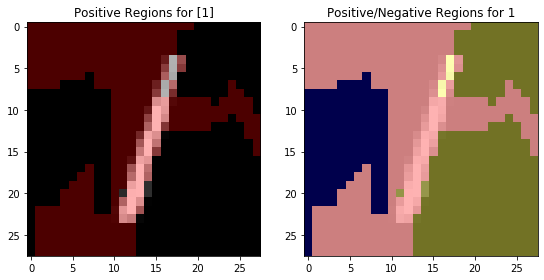

In [19]:
temp, mask = explanation.get_image_and_mask(int(np.where(y_test[case]==1)[0]),
                                            positive_only=True,
                                            num_features=10,
                                            hide_rest=False,
                                            min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(np.where(y_test[case]==1)[0]))
temp, mask = explanation.get_image_and_mask(int(np.where(y_test[case]==1)[0]),
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False,
                                            min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(int(np.where(y_test[case]==1)[0])))
plt.savefig('test.png')

# Tester

## Class

In [2]:
class Tester:
    def __init__(self,name1, model1, type1,name2, model2, type2, classes):
        self.models={}
        self.models[name1]=MyModel(model1,type1)
        self.models[name2]=MyModel(model2,type2)
        self.classes=classes
        self.names=(name1, name2)

    def __repr__():
        return self.models.__repr__()+'\n'+self.classes.__repr__()
    def lime_test_case(self, model,case,y, filename=None):
        explainer = lime_image.LimeImageExplainer(verbose = False)
        explain=explainer.explain_instance
        explanation = explain(np.array([[[x[0],x[0],x[0]]
                                            for x in y]
                                        for y in case]), 
                                classifier_fn =self.models[model].predict, 
                                top_labels=10,
                                hide_color=0,
                                num_samples=10000,
                                segmentation_fn=segmenter,
                                labels=np.array([str(x) 
                                            for x in range(10)]))
        print(y)
        print(np.where(y==1))
        try:
            temp, mask = explanation.get_image_and_mask(int(np.where(y==1)[0]),
                                                        positive_only=True,
                                                        num_features=10,
                                                        hide_rest=False,
                                                        min_weight = 0.01)
            print(self.models[model].ty)
            fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
            ax1.imshow(label2rgb(mask,temp, bg_label = 0), 
                       interpolation = 'nearest')
            ax1.set_title('Positive Regions for {}'.format(np.where(y==1)[0]))
            temp, mask = explanation.get_image_and_mask(int(np.where(y==1)[0]),
                                                        positive_only=False,
                                                        num_features=10,
                                                        hide_rest=False,
                                                        min_weight = 0.01)
            ax2.imshow(label2rgb(3-mask,
                                 temp,
                                 bg_label = 0),
                        interpolation = 'nearest')
            ax2.set_title('Positive/Negative Regions for {}'.format(int(
                np.where(y==1)[0])))
        except:
            temp, mask = explanation.get_image_and_mask(0,
                                                        positive_only=True,
                                                        num_features=10,
                                                        hide_rest=False,
                                                        min_weight = 0.01)
            print(self.models[model].ty)
            fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
            ax1.imshow(label2rgb(mask,temp, bg_label = 0), 
                       interpolation = 'nearest')
            ax1.set_title('Positive Regions for {}'.format(0))
            temp, mask = explanation.get_image_and_mask(int(0),
                                                        positive_only=False,
                                                        num_features=10,
                                                        hide_rest=False,
                                                        min_weight = 0.01)
            ax2.imshow(label2rgb(3-mask,
                                 temp,
                                 bg_label = 0),
                        interpolation = 'nearest')
            ax2.set_title('Positive/Negative Regions for {}'.format(int(0)))
        if(filename!=None):
            plt.savefig(filename)
        plt.show()
    
    
    
    
    
    def plot_confusion_matrix(self, y_true, y_pred, classes,
                                normalize=False,
                                title=None,
                                filename='test.pdf',
                                dirname='',
                                cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data

        classes = classes[unique_labels(y_true, y_pred)]
        print('classes:', classes)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots(figsize=(20,20))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                # ... and label them with the respective list entries
                xticklabels=classes, yticklabels=classes,
                title=title,
                ylabel='True label',
                xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                    rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.savefig(dirname+filename)
        plt.show()
        return ax
    def confmatrix_test(self,x_train,x_test,y_train,y_test):
        proy_train=[np.where(y==np.max(y))[0][0] for y in y_train]
        proy_test=[np.where(y==np.max(y))[0][0] for y in y_test]
        filenames={}
        for name,model in self.models.items():
            print(name, 'runing predictors')
            pred_train= [np.where(y==np.max(y))[0][0]
                         for y in model.predict(x_train)]
            pred_test= [np.where(y==np.max(y))[0][0]
                        for y in model.predict(x_test)]
            print(pred_train[0],pred_test[0])
            filenames[name]={}
            filenames[name]['conf']={'tr': name+'trainconf.png',
                                     'ts': name+'testconf.png'}
            print('generating conf matrices')
            self.plot_confusion_matrix(proy_train,
                                       pred_train,
                                       self.classes,
                                       title=name+'training confution matrix',
                                       filename=name+'trainconf.png')
            self.plot_confusion_matrix(proy_test,
                                       pred_test,
                                       self.classes,
                                       title=name+'test confution matrix',
                                       filename=name+'testconf.png')
            
        return filenames


    def stats(self,x_train,x_test,y_train,y_test,loss='mse'):
        proy_train=[np.where(y==np.max(y))[0][0] for y in y_train]
        proy_test=[np.where(y==np.max(y))[0][0] for y in y_test]
        scores={}
        names=self.names
        for name,model in self.models.items():
            pred_train= model.predict(x_train)
            pred_test= model.predict(x_test)
            pred1_train= [np.where(y==np.max(y))[0][0]
                         for y in pred_train]
            pred1_test= [np.where(y==np.max(y))[0][0]
                        for y in pred_test]
            with open('preddata.pkl','wb') as f:
                pk.dump([proy_train,
                         proy_test,
                         pred_train,
                         pred_test,
                         pred1_train,
                         pred1_test],
                        f)
            scores[name]={}
            scores[name]['acc']={'tr':accuracy_score(proy_train,pred1_train),
                                'ts':accuracy_score(proy_test,pred1_test)}
            scores[name]['loss']={
                                  'tr':mean_squared_log_error(np.array(y_train),
                                                              np.array(pred_train)),
                                  'ts':mean_squared_log_error(np.array(y_test),
                                                              np.array(pred_test))}
        accnames=[names[0]+' training',names[0]+ ' test',names[1]+' training',names[1]+ ' test']
        accvals=[scores[names[0]]['acc']['tr'],scores[names[0]]['acc']['ts'],scores[names[1]]['acc']['tr'],scores[names[1]]['acc']['ts']]
        lossnames=[names[0]+' training',names[0]+ ' test',names[1]+' training',names[1]+ ' test']
        lossvals=[scores[names[0]]['loss']['tr'],scores[names[0]]['loss']['ts'],scores[names[1]]['loss']['tr'],scores[names[1]]['loss']['ts']]
        print(accnames)
        print(accvals)
        print(lossnames)
        print(lossvals)
        plt.bar(accnames,accvals)
        plt.savefig('acc.png')
        plt.show()
        plt.bar(lossnames,lossvals)
        plt.savefig('loss.png')
        plt.show()
        return scores

    def lime_test(self,cases,Y,datasetname=None):
        filenames={}
        for case,n,y in zip(cases,range(len(cases)),Y):
            print(n)
            filenames[str(n)]={}
            self.lime_test_case(list(self.models.keys())[0],
                                case,
                                y,
                                str(list(self.models.keys())[0])+datasetname+'lime'+str(n)+'.png')
            
            self.lime_test_case(list(self.models.keys())[1],
                                case,
                                y,
                                list(self.models.keys())[1]+datasetname+'lime'+str(n)+'.png')
            filenames[str(n)]={list(self.models.keys())[0]:
                               list(self.models.keys())[0]+datasetname+'lime'+str(n)+'.png',
                               list(self.models.keys())[1]:
                               list(self.models.keys())[1]+datasetname+'lime'+str(n)+'.png',
                               }
        return filenames
    
    
    
    def find_lime_cases(self,x_data,y_data):
        y_proc=[np.argmax(x) for x in y_data]
        cases={}
        for name,model in self.models.items():
            pred=model.predict(x_data)
            sel=[np.argmax(x) for x in pred]
            cases[name]={}
            cases[name]['correct']={}
            cases[name]['incorrect']={}
            for y_pred,y_true,n in zip(sel,y_proc,range(len(y_proc))):
                if(y_pred==y_true):
                    cases[name]['correct'][n] = (y_pred, y_true)
                else:
                    cases[name]['incorrect'][n] = (y_pred, y_true)
        test_cases={'cc':-1,'ci':-1,'ic':-1,'ii':-1}
        names=list(cases.keys())
        print(names[0])
        zero_correct = cases[names[0]]['correct']
        zero_incorrect = cases[names[0]]['incorrect']
        one_correct = cases[names[1]]['correct']
        one_incorrect = cases[names[1]]['incorrect']
        for case in zero_correct:
            if(case in one_correct):
                test_cases['cc']=(case, (zero_correct[case], one_correct[case]))
                break
        for case in zero_correct:
            if(case in one_incorrect):
                test_cases['ci']=(case, (zero_correct[case], one_incorrect[case]))
                break
        for case in zero_incorrect:
            if(case in one_correct):
                test_cases['ic']=(case, (zero_incorrect[case], one_correct[case]))
                break
        for case in zero_incorrect:
            if(case in one_incorrect):
                test_cases['ii']=(case, (zero_incorrect[case], one_incorrect[case]))
                break
        return test_cases

    def run_test(self,x_train,x_test,y_train,y_test):
        print('finding test cases')
        names = self.names
        casests=self.find_lime_cases(x_test,y_test)
        xselts=[x_test[case[0]] for case in casests for value in case[1]]
        ypred=[value[0] for case in casests for value in case[1]]
        print(casests)
        print(self.names)
        yselts = keras.utils.to_categorical(y_test, self.num_classes)
        print('running lime test')
        filenamests=self.lime_test(xselts,ypred,'ts')
        print('running conf test')
        conffilenames=self.confmatrix_test(x_train,x_test,y_train,y_test)
        print('running stats test')
        stats=self.stats(x_train,x_test,y_train,y_test)
        print('done')
        limeinfo={
            'cc':np.where(yselts[0]==np.max(yselts[0])),
            'ci':[
                np.where(yselts[0]==np.max(yselts[0])),
                np.where(ciy==np.max(ciy))],
            'ic':[
                np.where(yselts[0]==np.max(yselts[0])),
                np.where(ciy==np.max(ciy))],
            'ii':[
                np.where(yselts[0]==np.max(yselts[0])),
                np.where(ciy==np.max(ciy)),
                np.where(ciy==np.max(ciy))]
        }
        print(limeinfo,filenamests,conffilenames,stats)
        return limeinfo,filenamests,conffilenames,stats
   # def generate_report(self, filenamestr,filenamests,conffilenames,stats):
        

NameError: name 'plt' is not defined

## commands

In [30]:
tester=Tester('ANN',model,'ann','RF',rdm_forest,'rf',np.array([str(x) for x in range(10)]))

In [33]:
np.argmax(tester.models['ANN'].predict(x_train[247]))

9

finding test cases


ANN
{'cc': 0, 'ci': 8, 'ic': 883, 'ii': 247}
['ANN', 'RF']
running lime test
0


100% |########################################################################|


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(array([7]),)
ann


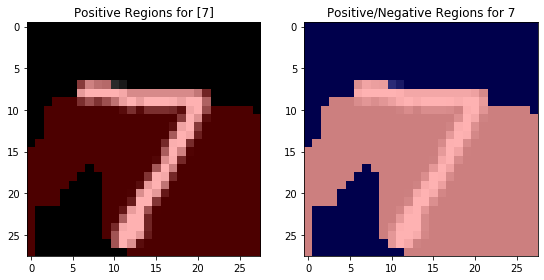

100% |########################################################################|


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(array([7]),)
rf


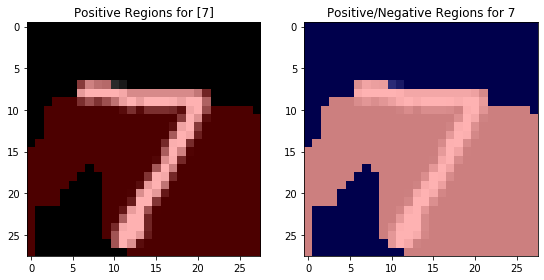

1


100% |########################################################################|


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(array([5]),)
ann


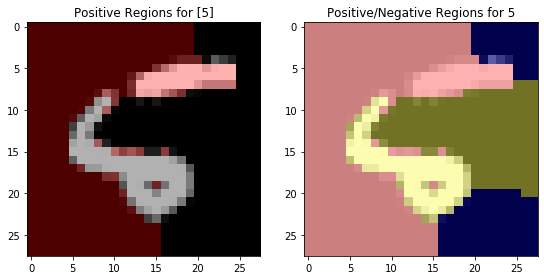

100% |########################################################################|


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(array([5]),)
rf


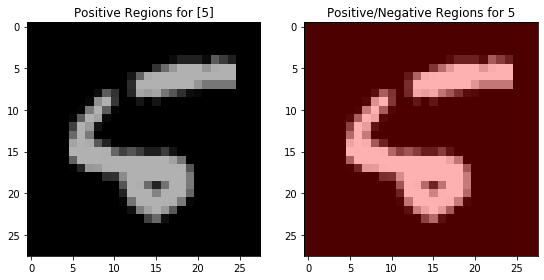

2


100% |########################################################################|


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(array([3]),)
ann


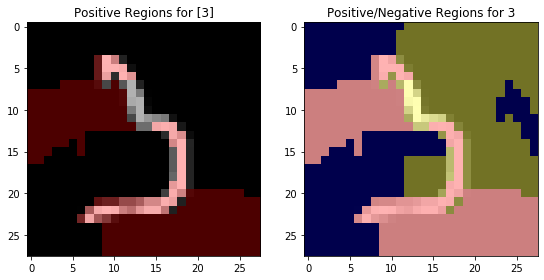

100% |########################################################################|


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(array([3]),)
rf


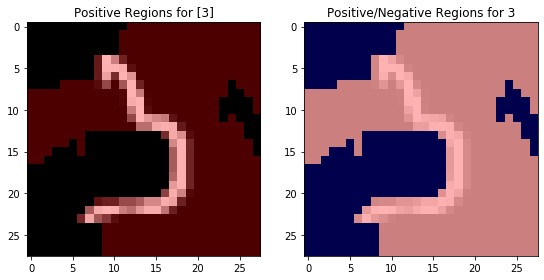

3


100% |########################################################################|


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(array([4]),)
ann


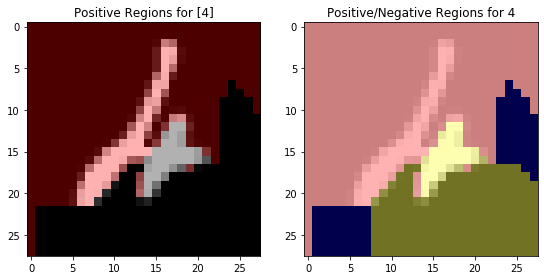

100% |########################################################################|


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(array([4]),)
rf


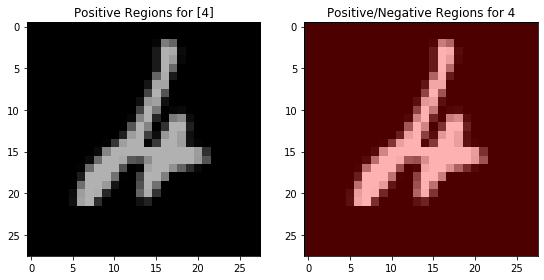

4


100% |########################################################################|


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(array([], dtype=int64), array([], dtype=int64))
ann


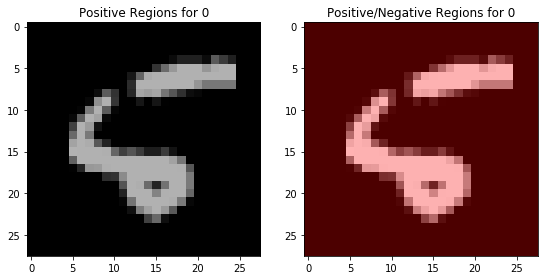

100% |########################################################################|


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(array([], dtype=int64), array([], dtype=int64))
rf


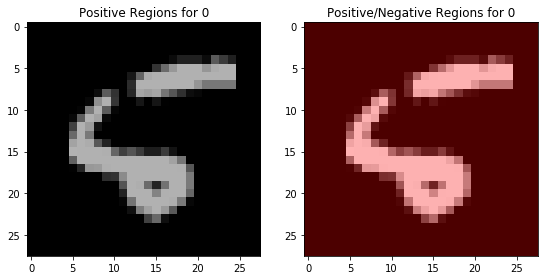

5


100% |########################################################################|


[[1.0422726e-04 2.5715963e-05 1.6189493e-05 2.1478064e-01 1.9839554e-06
  7.8430504e-01 1.1386393e-04 2.2040378e-05 2.0177869e-04 4.2856488e-04]]
(array([], dtype=int64), array([], dtype=int64))
ann


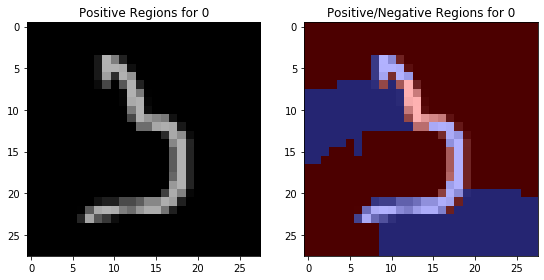

100% |########################################################################|


[[1.0422726e-04 2.5715963e-05 1.6189493e-05 2.1478064e-01 1.9839554e-06
  7.8430504e-01 1.1386393e-04 2.2040378e-05 2.0177869e-04 4.2856488e-04]]
(array([], dtype=int64), array([], dtype=int64))
rf


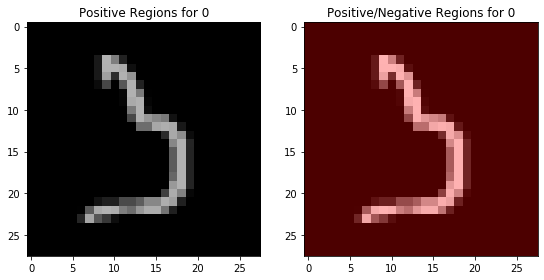

6


100% |########################################################################|


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(array([], dtype=int64), array([], dtype=int64))
ann


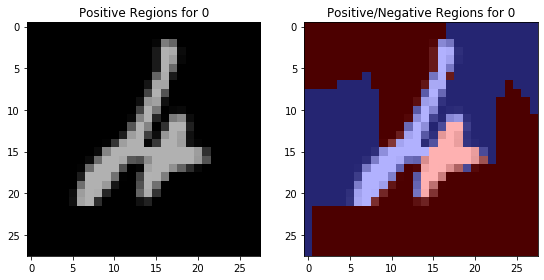

100% |########################################################################|


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(array([], dtype=int64), array([], dtype=int64))
rf


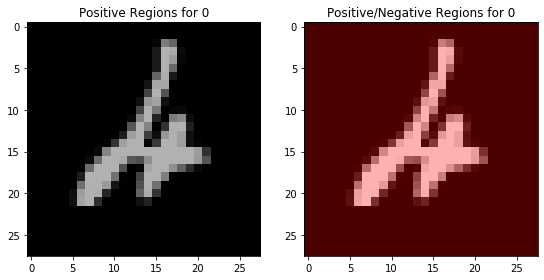

7


100% |########################################################################|


[[1.9043789e-04 1.4064101e-02 1.5517448e-01 3.5660624e-04 3.6226931e-01
  1.6487315e-02 4.4309485e-01 4.8936654e-05 8.2823252e-03 3.1733911e-05]]
(array([], dtype=int64), array([], dtype=int64))
ann


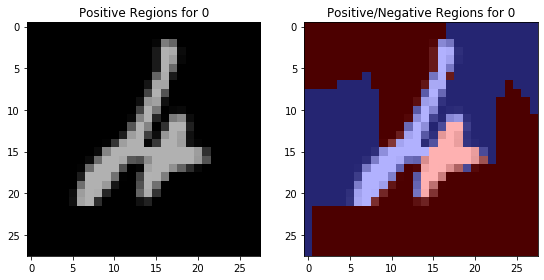

100% |########################################################################|


[[1.9043789e-04 1.4064101e-02 1.5517448e-01 3.5660624e-04 3.6226931e-01
  1.6487315e-02 4.4309485e-01 4.8936654e-05 8.2823252e-03 3.1733911e-05]]
(array([], dtype=int64), array([], dtype=int64))
rf


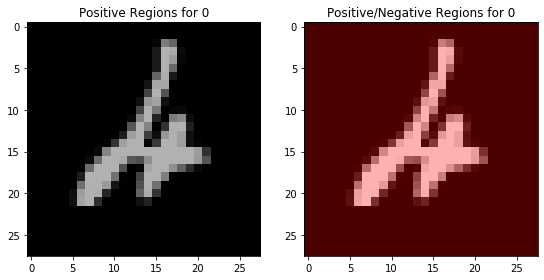

running conf test
ANN runing predictors
5 7
generating conf matrices
classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[5855    5    5    1    3    4   35    0   12    3]
 [   1 6636   37    4    8    0    5   15   32    4]
 [   7    8 5880   14   19    0    5   12    9    4]
 [   2    7   51 5992    1   25    3   21   15   14]
 [   3    5    5    0 5759    0   18    7   10   35]
 [   3    1    3   26    3 5337   28    1   15    4]
 [  10    7    2    1    7   26 5849    0   16    0]
 [   7    6   51   12   20    3    0 6115   10   41]
 [  16    8   22   14   15   33   25    4 5688   26]
 [  31    4   11    8   31   34    1   52   26 5751]]


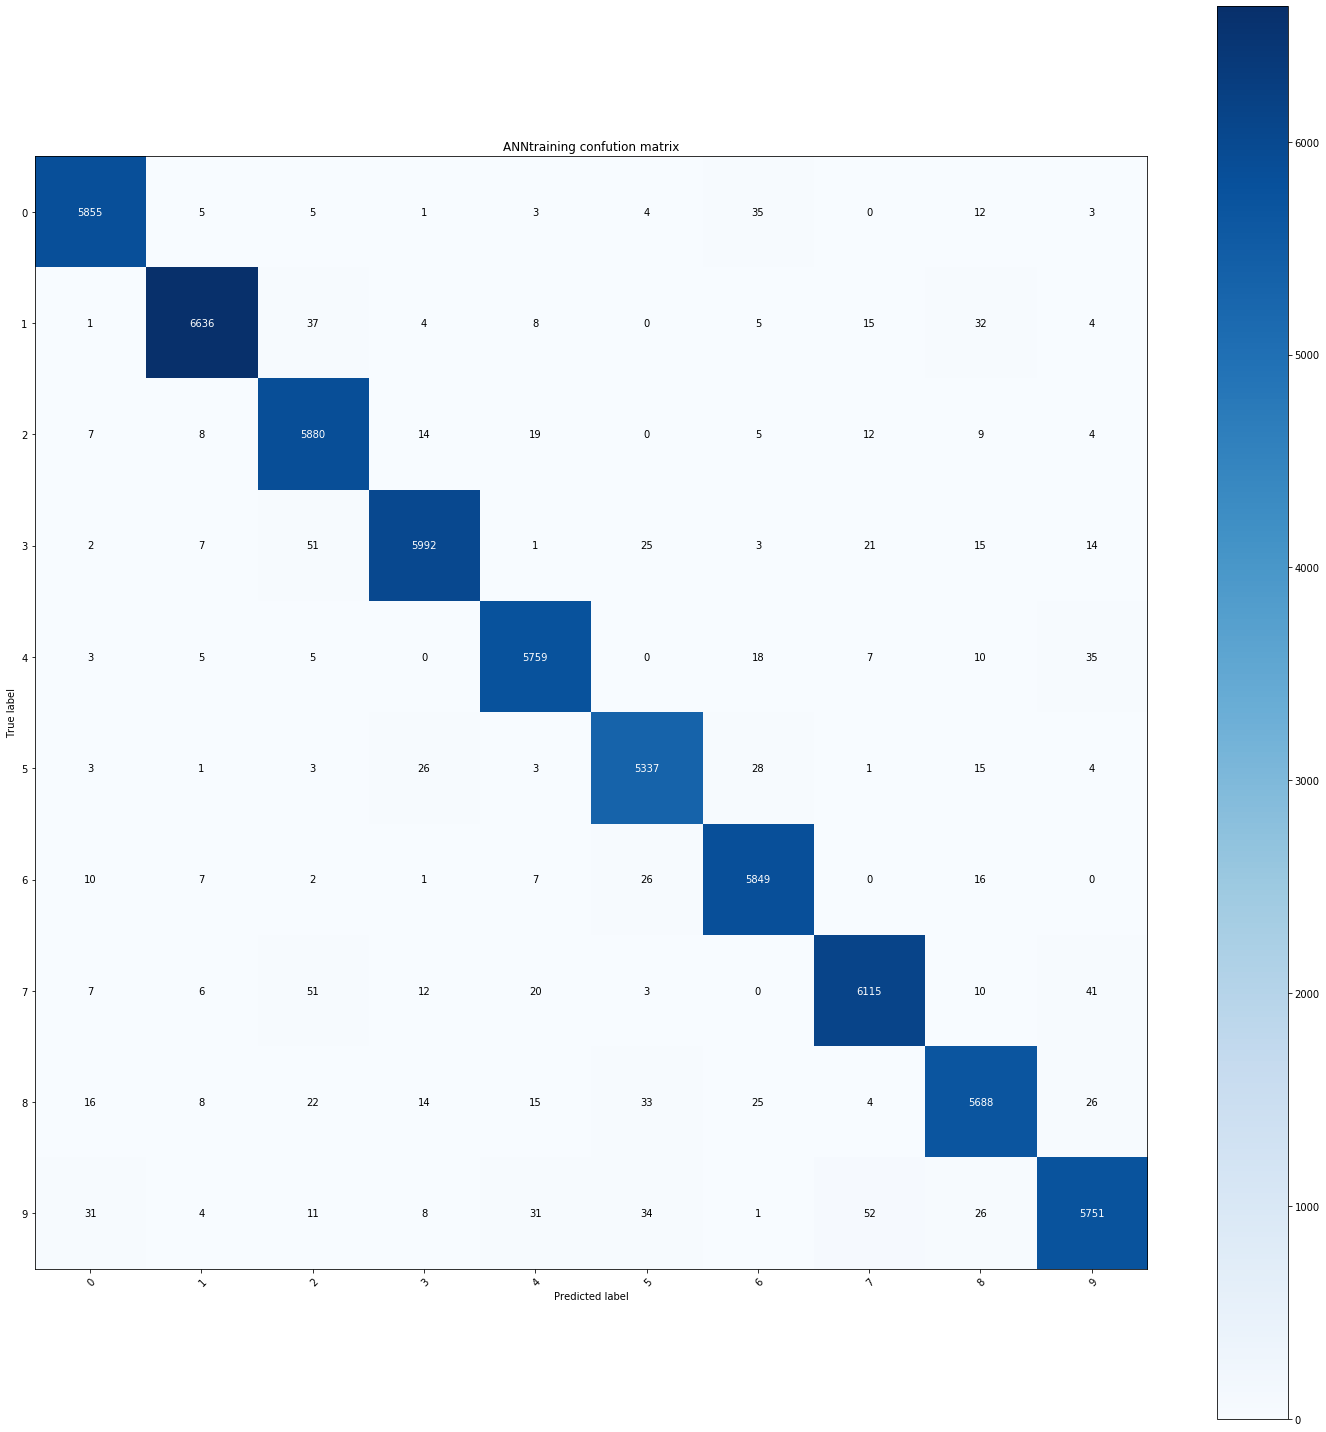

classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[ 972    0    2    0    0    0    5    1    0    0]
 [   0 1114    4    0    0    1    4    0   12    0]
 [   2    1 1013    1    4    0    2    8    1    0]
 [   0    0    5  989    0   10    0    2    2    2]
 [   1    0    0    0  962    0    5    0    3   11]
 [   1    0    0    6    0  880    3    0    1    1]
 [   5    2    0    0    3    4  941    0    3    0]
 [   2    1   23    1    2    1    0  987    3    8]
 [   7    1    4    3    5    2    4    3  941    4]
 [   8    4    2    2    6    4    0    4   11  968]]


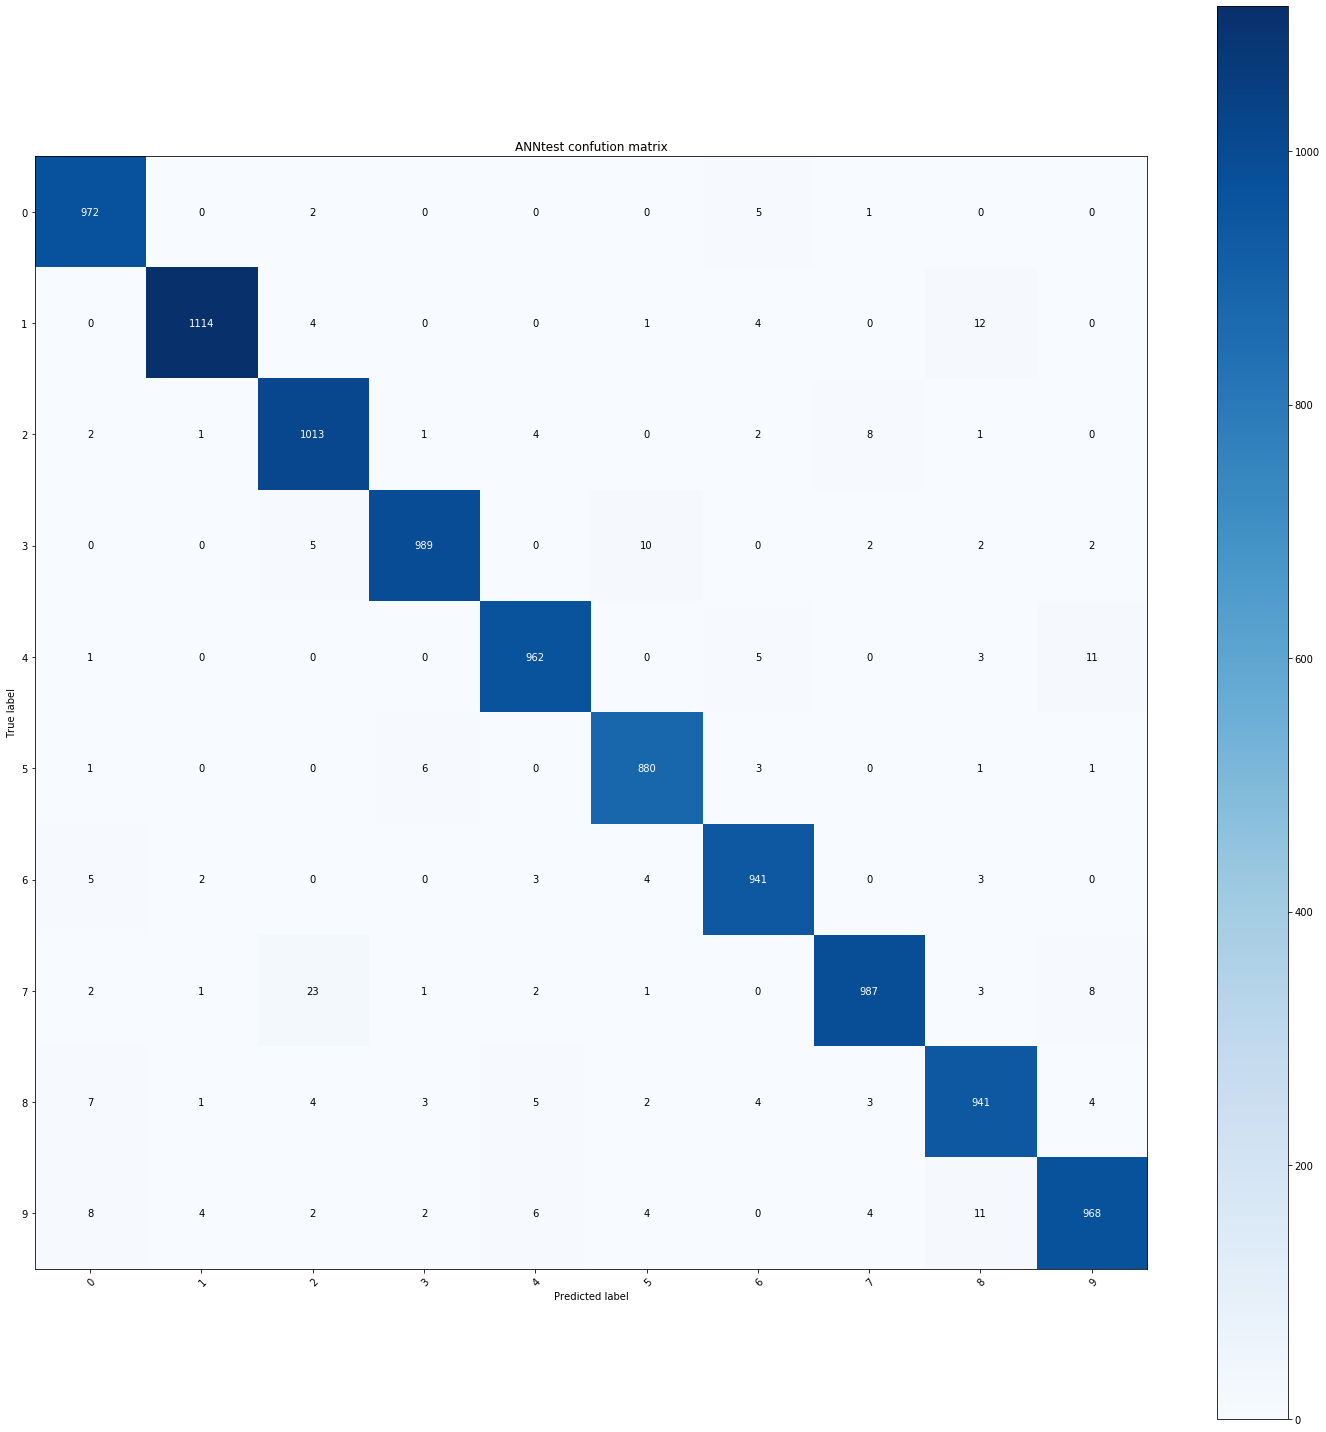

RF runing predictors
5 7
generating conf matrices
classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[5923    0    0    0    0    0    0    0    0    0]
 [   0 6742    0    0    0    0    0    0    0    0]
 [   0    0 5958    0    0    0    0    0    0    0]
 [   0    0    0 6131    0    0    0    0    0    0]
 [   0    0    0    0 5842    0    0    0    0    0]
 [   0    0    0    0    0 5421    0    0    0    0]
 [   0    0    0    0    0    0 5918    0    0    0]
 [   0    0    0    0    0    0    0 6265    0    0]
 [   0    0    0    0    0    0    0    0 5851    0]
 [   0    0    0    0    0    0    0    0    0 5949]]


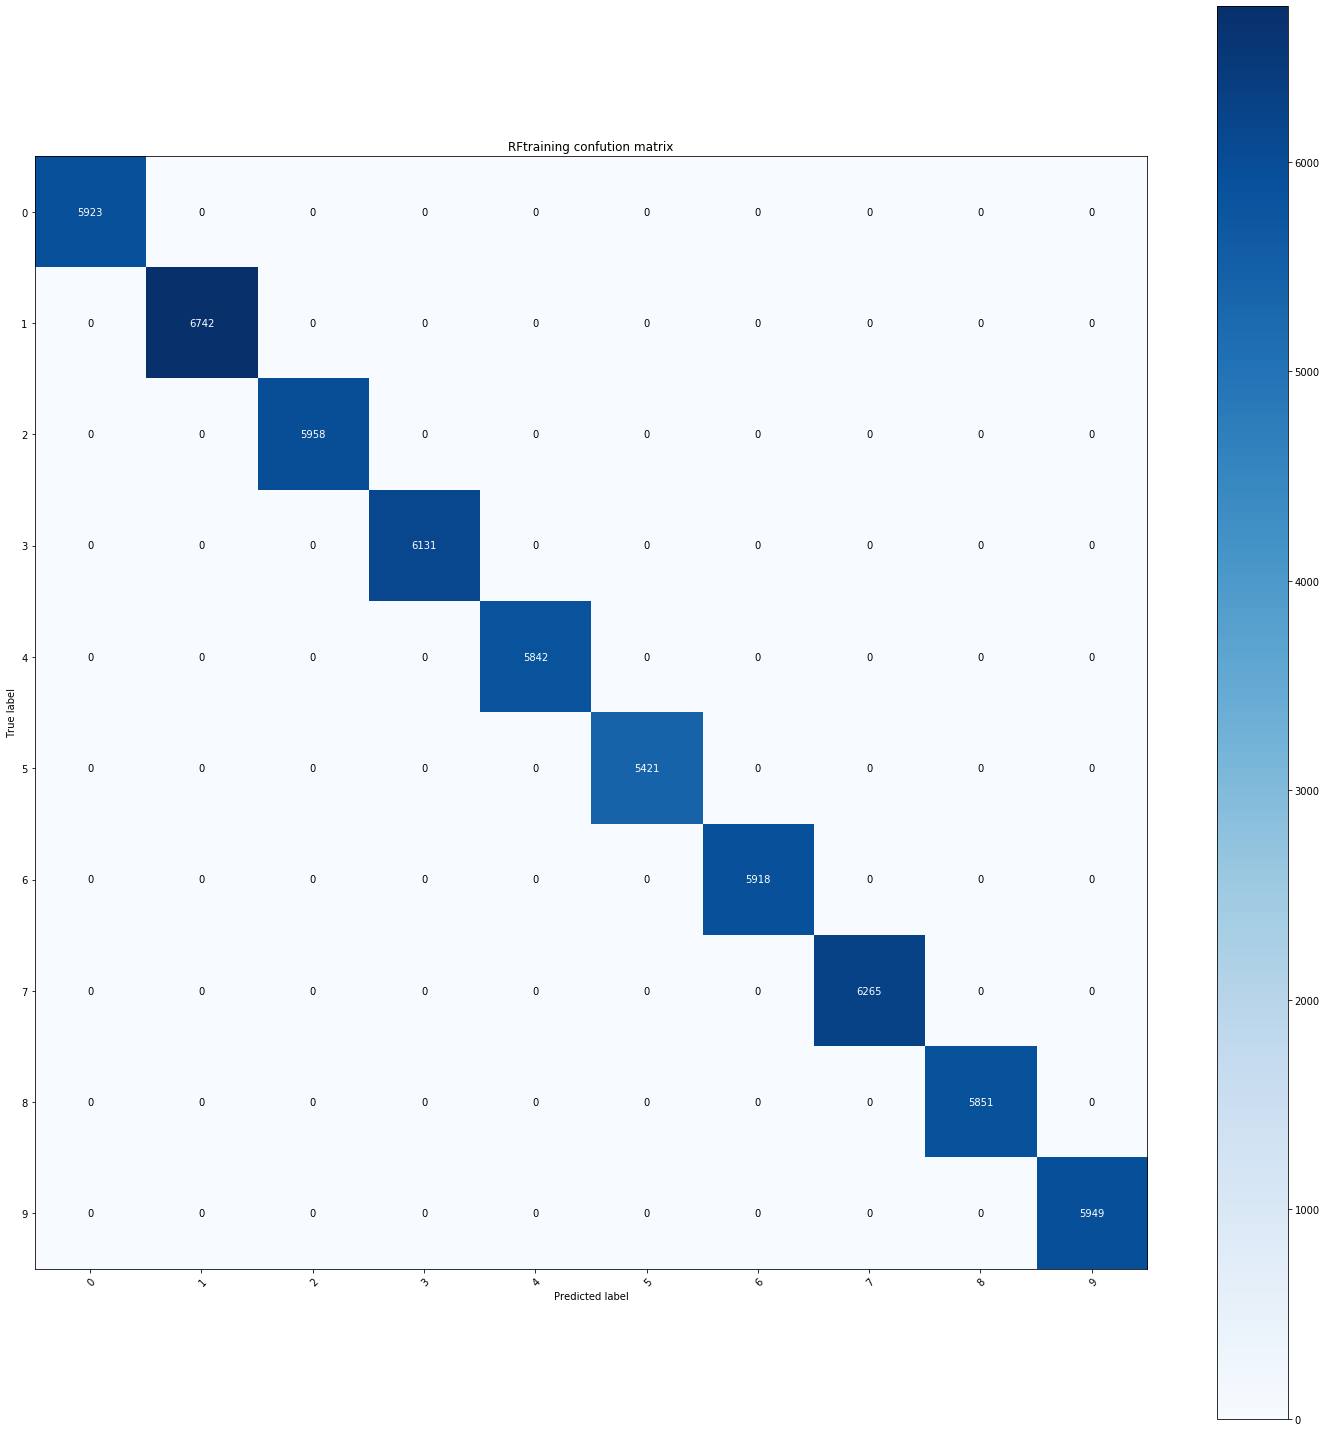

classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Confusion matrix, without normalization
[[ 979    0    0    0    0    0    0    1    0    0]
 [  20 1113    1    0    0    0    1    0    0    0]
 [ 106    0  921    0    0    0    0    4    1    0]
 [ 123    0    1  880    0    1    0    3    2    0]
 [  99    0    0    0  876    0    1    0    0    6]
 [ 126    0    0    1    0  763    1    0    1    0]
 [  64    2    0    0    1    0  891    0    0    0]
 [  88    0    8    0    0    0    0  931    0    1]
 [ 160    0    0    0    1    0    0    0  811    2]
 [ 112    0    0    1    3    0    0    1    0  892]]


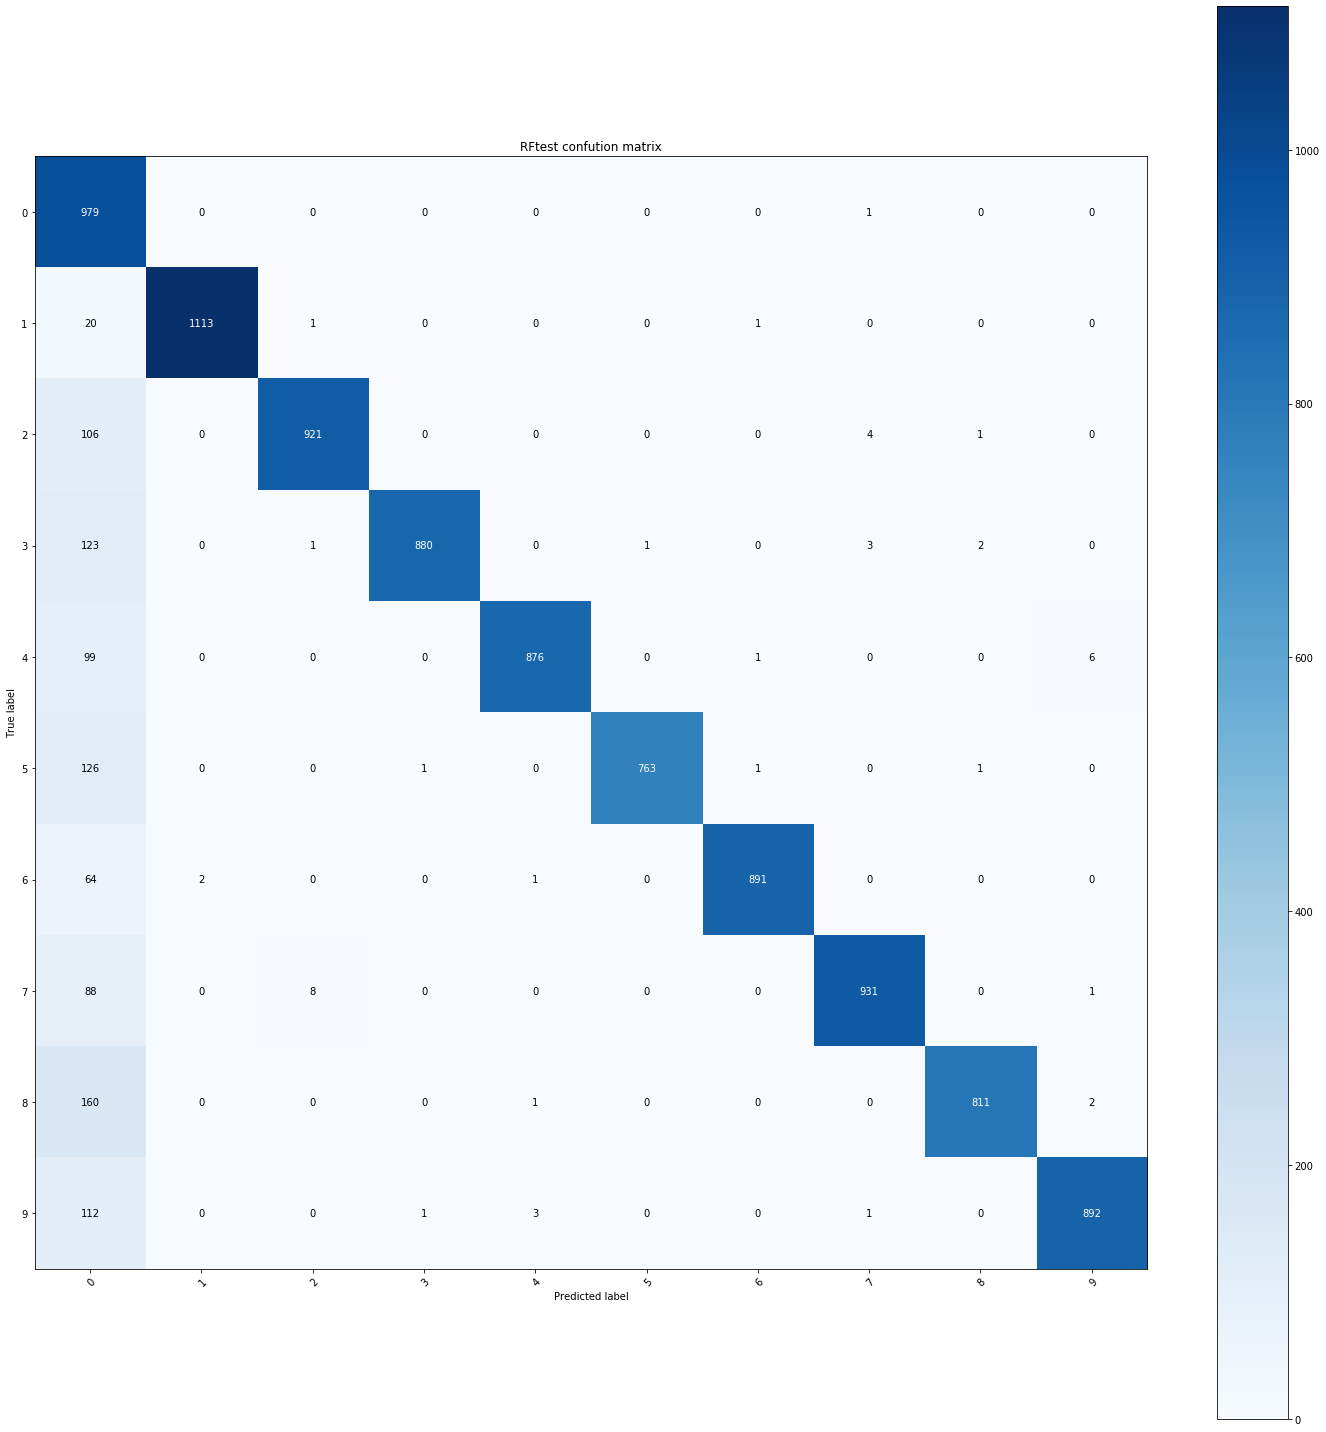

running stats test
['ANN training', 'ANN test', 'RF training', 'RF test']
[0.9810333333333333, 0.9767, 1.0, 0.9057]
['ANN training', 'ANN test', 'RF training', 'RF test']
[0.001437908, 0.0016805703, 0.0, 0.004905429]


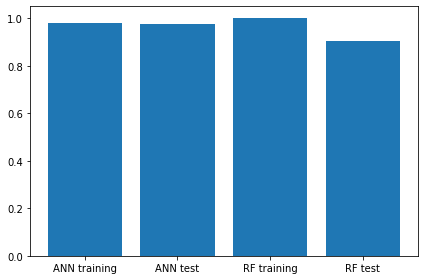

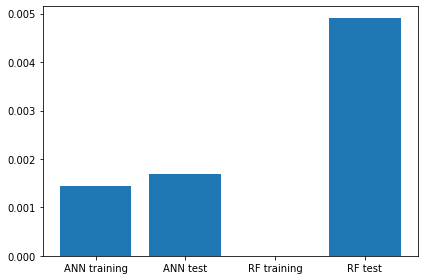

done
{'cc': (array([7]),), 'ci': [(array([7]),), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))], 'ic': [(array([7]),), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))], 'ii': [(array([7]),), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))]} {'0': {'ANN': 'ANNtslime0.png', 'RF': 'RFtslime0.png'}, '1': {'ANN': 'ANNtslime1.png', 'RF': 'RFtslime1.png'}, '2': {'ANN': 'ANNtslime2.png', 'RF': 'RFtslime2.png'}, '3': {'ANN': 'ANNtslime3.png', 'RF': 'RFtslime3.png'}, '4': {'ANN': 'ANNtslime4.png', 'RF': 'RFtslime4.png'}, '5': {'ANN': 'ANNtslime5.png', 'RF': 'RFtslime5.png'}, '6': {'ANN': 'ANNtslime6.png', 'RF': 'RFtslime6.png'}, '7': {'ANN': 'ANNtslime7.png', 'RF': 'RFtslime7.png'}} {'ANN': {'conf': {'tr': 'ANNtrainconf.png', 'ts': 'ANNtestconf.png'}}, 'RF': {'conf': {'tr': 'RFtrainconf.png', 'ts': 'RFtestconf.png'}}} {'ANN

In [37]:

%%time
limeinfo,filenamests,conffilenames,stats=tester.run_test(x_train,x_test,y_train,y_test)

In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10589971491517518237
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11360703215930382266
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14715117212119179661
physical_device_desc: "device: XLA_GPU device"
]


In [24]:
def generate(limeinfo,filenamests,conffilenames,stats,models):
    print(limeinfo,
          '\n_________________________________\n',
          filenamests,
          '\n_________________________________\n',
          conffilenames,
          '\n_________________________________\n',
          stats,
         '\n_________________________________\n')
    with open('tamplate.md','r') as f:
        template=f.read()
    
    name1=str(list(models.keys())[0])
    name2=str(list(models.keys())[1])
    text=template.replace('occ_',str(limeinfo['cc'][0][0]))
    
    text=text.replace('model1',name1).replace('model2',name2)
    print(name1,name2)
    # Lime
    
    
    # correct-correct
    text=text.replace('_lgcc1_',name1+' true')
    text=text.replace('_lgcc2_',name2+' true')
    text=text.replace('_filenamelgcc1_',filenamests['0'][name1])
    text=text.replace('_filenamelgcc2_',filenamests['0'][name2])
    
    # correct-incorrect
    text=text.replace('oci_',str(limeinfo['ci'][0][0][0]))
    text=text.replace('oci2',str(limeinfo['ci'][1][0][0]))
    text=text.replace('_lgci1_',name1+' true')
    text=text.replace('_lgci2c_',name2+' true')
    text=text.replace('_lgci2p_',name2+' predicted')
    text=text.replace('_filenamelgci1_',filenamests['1'][name1])
    text=text.replace('_filenamelgci2c_',filenamests['1'][name2])    
    text=text.replace('_filenamelgci2p_',filenamests['4'][name2])    
    
    # incorrect-correct
    text=text.replace('oic_',str(limeinfo['ic'][0][0][0]))
    text=text.replace('oic1',str(limeinfo['ic'][1][0][0]))
    text=text.replace('_lgic1c_',name1+' true')
    text=text.replace('_lgic1p_',name1+' predicted')
    text=text.replace('_lgic2_',name2+' true')
    text=text.replace('_filenamelgic1c_',filenamests['2'][name1])
    text=text.replace('_filenamelgic1p_',filenamests['5'][name2])    
    text=text.replace('_filenamelgic2_',filenamests['2'][name2])    
    
    # incorrect-incorrect
    text=text.replace('oii_',str(limeinfo['ii'][0][0][0]))
    text=text.replace('oii1',str(limeinfo['ii'][1][0][0]))
    text=text.replace('oii2',str(limeinfo['ii'][2][0][0]))
    text=text.replace('_lgii1p_',name1+' predicted')
    text=text.replace('_lgii2p_',name2+' predicted')
    text=text.replace('_lgii1c_',name1+' true')
    text=text.replace('_lgii2c_',name2+' true')
    text=text.replace('_filenamelgii1p_',filenamests['3'][name1])
    text=text.replace('_filenamelgii1c_',filenamests['3'][name1])
    text=text.replace('_filenamelgii2c_',filenamests['6'][name2])    
    text=text.replace('_filenamelgii2p_',filenamests['7'][name2])    
    
    
    # conf matrices
    text=text.replace('_cg1tr_',name1 +' training confution matrix')
    text=text.replace('_cg1ts_',name1 +' test confution matrix')
    text=text.replace('_cg2tr_',name2 +' training confution matrix')
    text=text.replace('_cg2ts_',name2 +' test confution matrix')
    
    text=text.replace('_filenamecg1tr_',conffilenames[name1]['conf']['tr'])
    text=text.replace('_filenamecg1ts_',conffilenames[name1]['conf']['ts'])
    text=text.replace('_filenamecg2tr_',conffilenames[name2]['conf']['tr'])
    text=text.replace('_filenamecg2ts_',conffilenames[name2]['conf']['ts'])
    # stats
    
    text=text.replace('tracc1val',str(stats[name1]['acc']['tr']))
    text=text.replace('tsacc1val',str(stats[name1]['acc']['ts']))
    text=text.replace('tracc2val',str(stats[name2]['acc']['tr']))
    text=text.replace('tsacc2val',str(stats[name2]['acc']['ts']))
    text=text.replace('trloss1val',str(stats[name1]['loss']['tr']))
    text=text.replace('tsloss1val',str(stats[name1]['loss']['ts']))
    text=text.replace('trloss2val',str(stats[name2]['loss']['tr']))
    text=text.replace('tsloss2val',str(stats[name2]['loss']['ts']))
    
    text=text.replace('_filenameacc_','acc.png')
    text=text.replace('_filenameloss_','loss.png')
    print(text)
    with open('report.md','w') as f:
        f.write(text)
    print(text)

In [25]:
limeinfo

{'cc': (array([7]),),
 'ci': [(array([7]),),
  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))],
 'ic': [(array([7]),),
  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))],
 'ii': [(array([7]),),
  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
  (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))]}

In [26]:
generate(limeinfo,filenamests,conffilenames,stats,tester.models)

{'cc': (array([7]),), 'ci': [(array([7]),), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))], 'ic': [(array([7]),), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))], 'ii': [(array([7]),), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])), (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))]} 
_________________________________
 {'0': {'ANN': 'ANNtslime0.png', 'RF': 'RFtslime0.png'}, '1': {'ANN': 'ANNtslime1.png', 'RF': 'RFtslime1.png'}, '2': {'ANN': 'ANNtslime2.png', 'RF': 'RFtslime2.png'}, '3': {'ANN': 'ANNtslime3.png', 'RF': 'RFtslime3.png'}, '4': {'ANN': 'ANNtslime4.png', 'RF': 'RFtslime4.png'}, '5': {'ANN': 'ANNtslime5.png', 'RF': 'RFtslime5.png'}, '6': {'ANN': 'ANNtslime6.png', 'RF': 'RFtslime6.png'}, '7': {'ANN': 'ANNtslime7.png', 'RF': 'RFtslime7.png'}} 
_________________________________
 {'ANN': {'conf': {'tr': 'ANNtrainconf.png', 'ts': 'ANNtestconf.png'}}, 'RF':

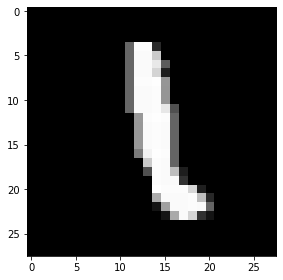

In [36]:
plt.imshow(x_train[248][:,:,[0,0,0]])

In [6]:
!git add *
!git commit -m 'Update'
!git push

[master 06a67ac] Update
 1 file changed, 78 insertions(+), 29 deletions(-)
Username for 'https://github.com': ^C


In [8]:
!git push --h

error: unknown option `h'
usage: git push [<options>] [<repository> [<refspec>...]]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --repo <repository>   repository
    --all                 push all refs
    --mirror              mirror all refs
    -d, --delete          delete refs
    --tags                push tags (can't be used with --all or --mirror)
    -n, --dry-run         dry run
    --porcelain           machine-readable output
    -f, --force           force updates
    --force-with-lease[=<refname>:<expect>]
                          require old value of ref to be at this value
    --recurse-submodules[=<check|on-demand|no>]
                          control recursive pushing of submodules
    --thin                use thin pack
    --receive-pack <receive-pack>
                          receive pack program
    --exec <receive-pack>
                          receive pack program
    -u, --set-upstream    set upstream for git pull/st